In [ ]:
!pip install fasttext xgboost scikit-learn pandas imbalanced-learn --quiet

import pandas as pd
import numpy as np
import fasttext
import fasttext.util
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib
import os

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
fasttext.util.download_model('pl', if_exists='ignore')

'cc.pl.300.bin'

In [3]:
ft_model = fasttext.load_model('cc.pl.300.bin')

In [9]:
def get_ft_vector(text):
    return ft_model.get_sentence_vector(text)

In [ ]:
def prepare_data(train_path, test_path, smote=True):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    X_train = np.vstack(train_df['text'].apply(get_ft_vector))
    y_train = train_df['label'].values
    X_test = np.vstack(test_df['text'].apply(get_ft_vector))
    y_test = test_df['label'].values

    if smote:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class distribution in train after SMOTE: {np.bincount(y_train)}")

    return X_train, y_train, X_test, y_test

In [ ]:
def train_and_evaluate_xgb(
    X_train, y_train, X_test, y_test,
    param_grid, verbose=2,
    save_dir='xgb_results',
    model_name='xgb_model'
):
    os.makedirs(save_dir, exist_ok=True)

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        xgb,
        param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=verbose
    )
    print("Start strojenia hiperparametrów...")
    grid_search.fit(X_train, y_train)

    print("\nNajlepsze parametry:", grid_search.best_params_)
    print(f"Najlepszy wynik F1 z walidacji krzyżowej: {grid_search.best_score_:.4f}")

    best_xgb = grid_search.best_estimator_
    #best_xgb.fit(X_train, y_train)

    model_path = os.path.join(save_dir, f"{model_name}.joblib")
    joblib.dump(best_xgb, model_path)
    print(f"\n✅ Model zapisany do: {model_path}")

    y_pred = best_xgb.predict(X_test)
    y_proba = best_xgb.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print("\n=== Evaluation Metrics (Final Model on Test Set) ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for XGB - The Best Variant")
    cm_path = os.path.join(save_dir, f"{model_name}_confusion_matrix.png")
    plt.savefig(cm_path)
    print(f"✅ Zapisano wykres: {cm_path}")
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("ROC Curve for XGB - The Best Variant")
    roc_path = os.path.join(save_dir, f"{model_name}_roc_curve.png")
    plt.savefig(roc_path)
    print(f"✅ Zapisano wykres: {roc_path}")
    plt.show()

In [12]:
param_grid_xgb = {
    'n_estimators': [100, 300],
    'max_depth': [4, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0],
}

In [13]:
def run_pipeline_xgb(train_path, test_path, smote=True, param_grid=param_grid_xgb):
    X_train, y_train, X_test, y_test = prepare_data(train_path, test_path, smote=smote)
    train_and_evaluate_xgb(X_train, y_train, X_test, y_test, param_grid)

Train shape: (18380, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190 9190]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 16 candidates, totalling 64 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:01:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Najlepsze parametry: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Najlepszy wynik F1 z walidacji krzyżowej: 0.9782

✅ Model zapisany do: xgb_results/xgb_model.joblib

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8950
Precision: 0.7231
Recall:    0.3507
F1-score:  0.4724
ROC-AUC:   0.9026

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       866
           1       0.72      0.35      0.47       134

    accuracy                           0.90      1000
   macro avg       0.82      0.66      0.71      1000
weighted avg       0.88      0.90      0.88      1000

✅ Zapisano wykres: xgb_results/xgb_model_confusion_matrix.png


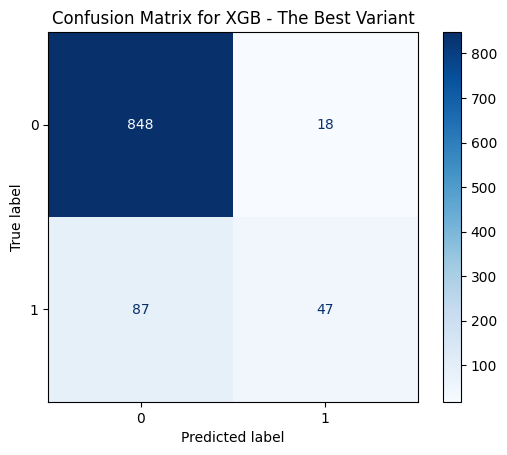

✅ Zapisano wykres: xgb_results/xgb_model_roc_curve.png


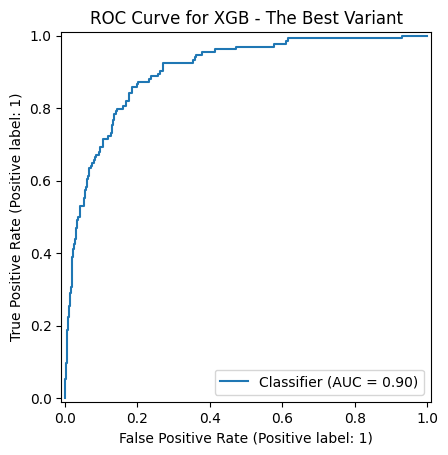

In [15]:
run_pipeline_xgb("v1_training_variant1_raw.csv", "v1_test_variant1_raw.csv", smote=True)

Train shape: (18380, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190 9190]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 16 candidates, totalling 64 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:21:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Najlepsze parametry: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Najlepszy wynik F1 z walidacji krzyżowej: 0.9795

✅ Model zapisany do: xgb_results/xgb_model.joblib

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8960
Precision: 0.7206
Recall:    0.3657
F1-score:  0.4851
ROC-AUC:   0.9026

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       866
           1       0.72      0.37      0.49       134

    accuracy                           0.90      1000
   macro avg       0.81      0.67      0.71      1000
weighted avg       0.88      0.90      0.88      1000

✅ Zapisano wykres: xgb_results/xgb_model_confusion_matrix.png


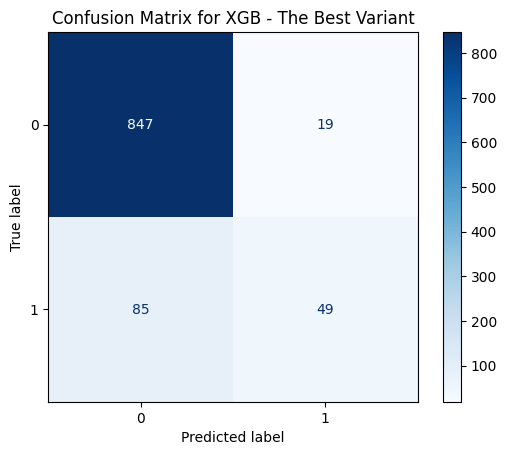

✅ Zapisano wykres: xgb_results/xgb_model_roc_curve.png


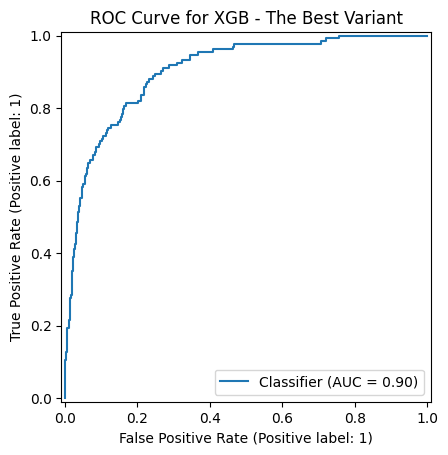

In [17]:
run_pipeline_xgb("v1_training_variant2_light.csv", "v1_test_variant2_light.csv", smote=True)

Train shape: (18314, 300), Test shape: (999, 300)
Class distribution in train after SMOTE: [9157 9157]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 16 candidates, totalling 64 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:54:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Najlepsze parametry: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 300, 'subsample': 1.0}
Najlepszy wynik F1 z walidacji krzyżowej: 0.9757

✅ Model zapisany do: xgb_results/xgb_model.joblib

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8909
Precision: 0.7119
Recall:    0.3134
F1-score:  0.4352
ROC-AUC:   0.8812

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       865
           1       0.71      0.31      0.44       134

    accuracy                           0.89       999
   macro avg       0.81      0.65      0.69       999
weighted avg       0.88      0.89      0.87       999

✅ Zapisano wykres: xgb_results/xgb_model_confusion_matrix.png


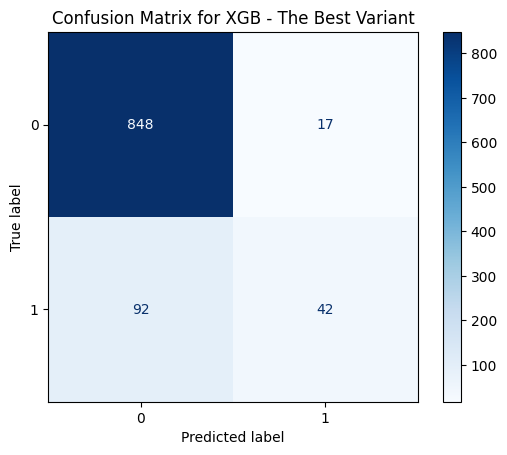

✅ Zapisano wykres: xgb_results/xgb_model_roc_curve.png


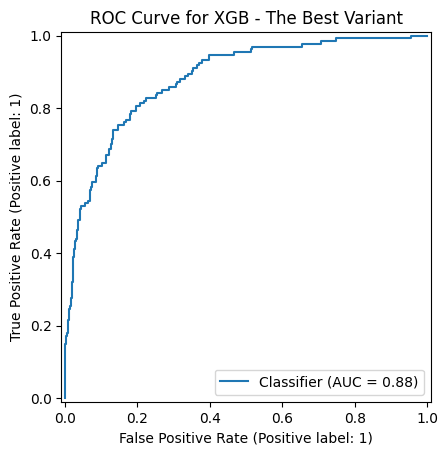

In [46]:
run_pipeline_xgb("v1_training_variant3_full.csv", "v1_test_variant3_full.csv", smote=True)